<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/MLP_Bin%C3%A1rio_Zero_Day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Mounted at /content/gdrive


In [ ]:
pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [ ]:
# Usando shape
num_amostras = encoded.shape[0]
print(f"Número de amostras: {num_amostras}")

# Usando len()
num_amostras_len = len(encoded)
print(f"Número de amostras (usando len): {num_amostras_len}")

Número de amostras: 1215890
Número de amostras (usando len): 1215890


In [ ]:
# Exibir os nomes de todas as colunas
colunas = encoded.columns.tolist()  # Converte o Index em uma lista
print("Nomes das colunas:")
for coluna in colunas:
    print(coluna)

Nomes das colunas:
Unnamed: 0
Seq
Dur
RunTime
Mean
Sum
Min
Max
sTos
dTos
sTtl
dTtl
sHops
dHops
TotPkts
SrcPkts
DstPkts
TotBytes
SrcBytes
DstBytes
Offset
sMeanPktSz
dMeanPktSz
Load
SrcLoad
DstLoad
Loss
SrcLoss
DstLoss
pLoss
SrcGap
DstGap
Rate
SrcRate
DstRate
SrcWin
DstWin
sVid
dVid
SrcTCPBase
DstTCPBase
TcpRtt
SynAck
AckDat
Label
Attack Type
Attack Tool
 *        
 *    V   
 *    f   
 e        
 e    f   
 e &      
 e *      
 e d      
 e g      
 e i      
 e r      
 e s      
 eU       
e        
arp
icmp
ipv6-icmp
llc
lldp
sctp
tcp
udp
ACC
CON
ECO
FIN
INT
NRS
REQ
RSP
RST
TST
URP
Shutdown
Start
Status
39
4
52
54
af11
af12
af41
cs0
cs4
cs6
cs7
ef
nan


In [ ]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [ ]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

Features
* Seq: Sequência de pacotes.
* Offset: Deslocamento em bytes.
* sTtl: Time to Live da fonte.
* tcp: Indica se o protocolo TCP está sendo usado.
* AckDat: Dados de reconhecimento.
* RST: Sinalizador de reinício TCP.
* INT: Interrupções no fluxo de dados.
* TcpRtt: Tempo de ida e volta do TCP.
* icmp: Indica se o protocolo ICMP está presente.
* sMeanPktSz: Tamanho médio do pacote da fonte.
* FIN: Sinalizador de finalização de conexão.
* sHops: Número de saltos até o destino.
* Mean: Valor médio de um conjunto de dados.
* dTtl: Time to Live do destino.
* SrcBytes: Bytes enviados da fonte.
* TotBytes: Total de bytes.
* dMeanPktSz: Tamanho médio do pacote do destino.
* Status: Estado da conexão.
* cs0: Parâmetro de controle.
* SrcWin: Janela de origem TCP.
* sTos: Tipo de serviço.
* CON: Conexões.
* REQ: Requisições.
* Loss: Taxa de perda de pacotes.

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.optimizers import Adam


# Definir as features
features = [
    'Seq', 'Offset', 'sTtl', 'e        ', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss'
]

# Separar as features e os rótulos
X = encoded[features]  # Usar apenas as colunas selecionadas
y = encoded['Label'].values

# Codificar os rótulos para valores numéricos
#label_encoder = LabelEncoder()
#y = label_encoder.fit_transform(y)  # Transforma 'Benign' e 'Malign' em 0 e 1

# Definir os ataques de zero-day
zero_day_attacks = ['ICMPFlood']

# Filtrar os dados para excluir os ataques de zero-day do conjunto de treinamento
train_data = encoded[~encoded['Attack Type'].isin(zero_day_attacks)]

# Dividir os dados de treinamento e teste
X_train = train_data[features]
y_train = train_data['Label'].values

X_test = encoded[encoded['Attack Type'].isin(zero_day_attacks)][features]
y_test = encoded[encoded['Attack Type'].isin(zero_day_attacks)]['Label'].values

# Codificar os rótulos para valores numéricos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Treinamento sem ataques zero-day
y_test = label_encoder.transform(y_test)  # Teste com ataques zero-day

# Identificar colunas categóricas
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Aplicar OneHotEncoder nas colunas categóricas
transformer = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_cols)],
    remainder='passthrough'
)

# Transformar as features
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

# Normalização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

import pandas as pd

print(pd.Series(y).value_counts())

Malicious    738153
Benign       477737
Name: count, dtype: int64


In [ ]:
# Criar o objeto de undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Aplicar o undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)

In [ ]:
print(pd.Series(y_resampled).value_counts())

0    477737
1    477737
Name: count, dtype: int64


In [ ]:
# Dividir os dados em treino e teste
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
print("Amostras de treino:", len(X_train))
print("Amostras de teste:", len(X_test))

Amostras de treino: 764379
Amostras de teste: 191095


In [ ]:
import psutil
import time
from keras.callbacks import Callback

# Função para monitorar recursos
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

# Callback personalizado para monitorar CPU e memória
class ResourceMonitor(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Antes da época começar
        self.start_time = time.time()
        self.start_cpu, self.start_memory = monitor_resource_usage()
        print(f"\n[Início da Época {epoch + 1}]")
        print(f"CPU inicial: {self.start_cpu:.2f}%, Memória inicial: {self.start_memory:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        # Após a época terminar
        end_time = time.time()
        end_cpu, end_memory = monitor_resource_usage()
        elapsed_time = end_time - self.start_time
        memory_diff = end_memory - self.start_memory

        print(f"[Fim da Época {epoch + 1}]")
        print(f"CPU final: {end_cpu:.2f}%, Memória consumida: {memory_diff:.2f} MB, Tempo gasto: {elapsed_time:.2f} segundos")

# Instanciar o callback
resource_monitor = ResourceMonitor()


[Início da Época 1]
CPU inicial: 1.50%, Memória inicial: 4822.40 MB
Epoch 1/50
23867/23887 [============================>.] - ETA: 0s - loss: 1.9125 - accuracy: 0.5199[Fim da Época 1]
CPU final: 0.20%, Memória consumida: 86.60 MB, Tempo gasto: 53.91 segundos
23887/23887 [==============================] - 54s 2ms/step - loss: 1.9120 - accuracy: 0.5199 - val_loss: 1.2384 - val_accuracy: 0.5540

[Início da Época 2]
CPU inicial: 0.10%, Memória inicial: 4909.00 MB
Epoch 2/50
23863/23887 [============================>.] - ETA: 0s - loss: 1.1574 - accuracy: 0.5440[Fim da Época 2]
CPU final: 0.00%, Memória consumida: 11.91 MB, Tempo gasto: 50.66 segundos
23887/23887 [==============================] - 51s 2ms/step - loss: 1.1570 - accuracy: 0.5440 - val_loss: 0.6814 - val_accuracy: 0.5580

[Início da Época 3]
CPU inicial: 0.00%, Memória inicial: 4920.91 MB
Epoch 3/50
23873/23887 [============================>.] - ETA: 0s - loss: 0.6801 - accuracy: 0.5620[Fim da Época 3]
CPU final: 0.10%, Memór

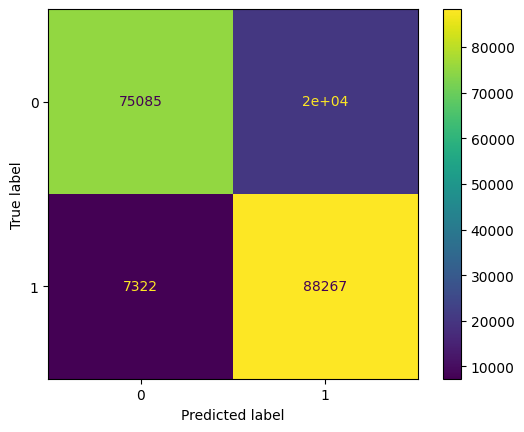

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.regularizers import l2
import time

# Codificar os rótulos novamente para garantir que sejam numéricos
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Construir o modelo MLP
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(96, activation='relu', kernel_regularizer=l2(0.01)))  # Camada de entrada com 96 neurônios
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Primeira camada oculta
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Segunda camada oculta
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Terceira camada oculta
model.add(Dense(1, activation='sigmoid'))  # Camada de saída para classificação binária
model.add(BatchNormalization())

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, resource_monitor])

# Avaliar o desempenho no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Gerar a matriz de confusão
y_pred = model.predict(X_test) > 0.5  # Converter as previsões em 0 ou 1
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Aguardar e monitorar o uso de recursos (opcional)
time.sleep(1)

5972/5972 [==============================] - 6s 1ms/step


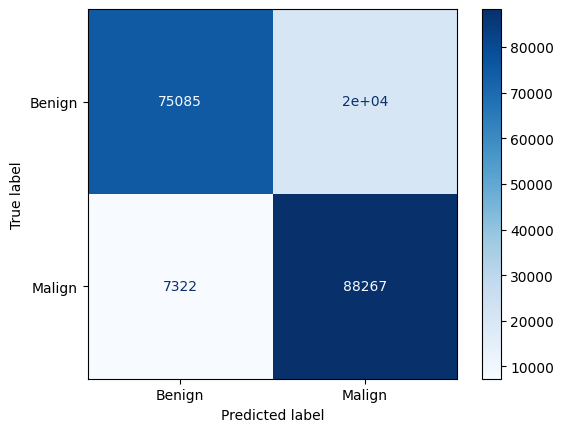

In [ ]:
#Matriz de Confusão

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malign"])
disp.plot(cmap='Blues')

In [ ]:
#Maligno
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred_classes, pos_label=1)
recall = recall_score(y_test, y_pred_classes, pos_label=1)
f1 = f1_score(y_test, y_pred_classes, pos_label=1)

print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precisão: 0.8121135727955248
Recall: 0.92340122817479
F1 Score: 0.864189311572032


In [ ]:
#Benigno
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred_classes, pos_label=0)
recall = recall_score(y_test, y_pred_classes, pos_label=0)
f1 = f1_score(y_test, y_pred_classes, pos_label=0)

print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precisão: 0.9111483247782348
Recall: 0.7861809729231671
F1 Score: 0.8440642336422859


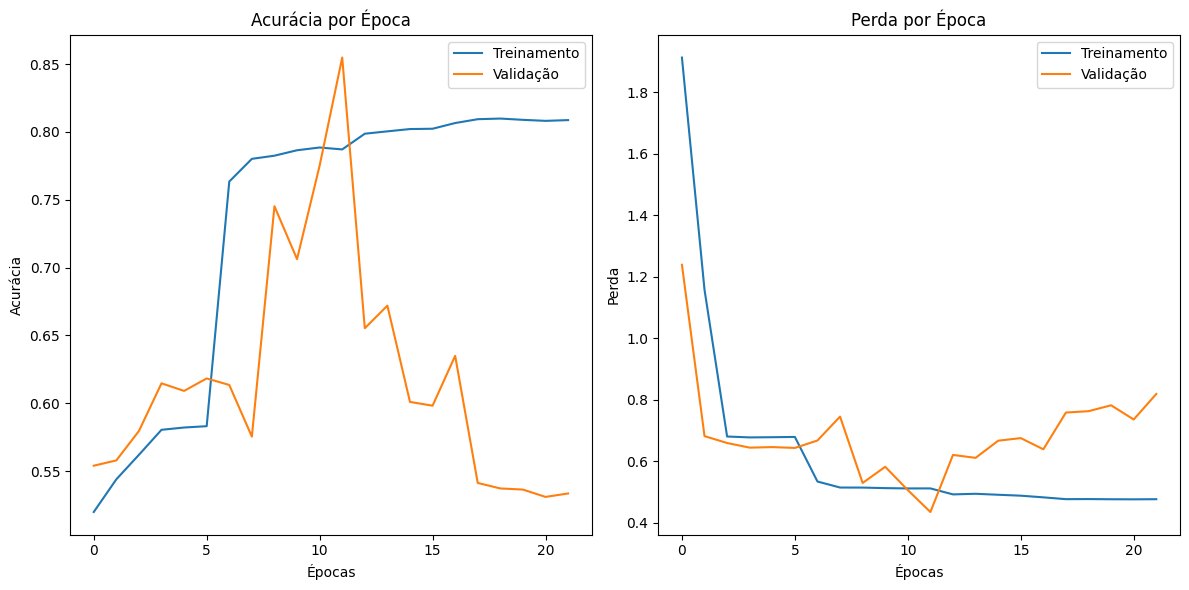

In [ ]:
# Gráfico de Acurácia
plt.figure(figsize=(12, 6))

# Acurácia de treino
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda por Época')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Supondo que 'model' seja seu modelo treinado
y_pred_prob = model.predict(X_test).flatten()  # Usando .flatten() para transformar em um vetor 1D

5972/5972 [==============================] - 6s 1ms/step


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [ ]:
roc_auc = auc(fpr, tpr)

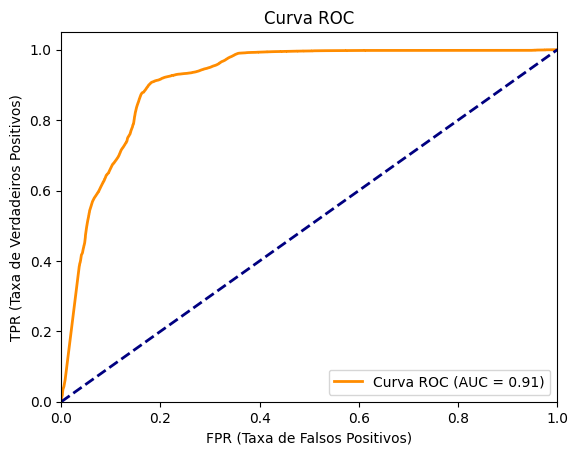

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular a AUC
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha diagonal (chance aleatória)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (Taxa de Falsos Positivos)')
plt.ylabel('TPR (Taxa de Verdadeiros Positivos)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()